# Lazy Covariance weighting applied to a PRISIM foreground simulation.

In this note, I will experiment with applying two variations of lazy covariance weighting to delay-transform power spectra in the hopes of achieving decorrelation without having to resort to an empirical covariance matrix. 

## Lazy Enough (LE) Weights. 

Lets try to derive a simple (lazy) weighting based on the covariance matrix of foregrounds that does not depend on data. 

To this end, I assume a point-source dominated sky which gives a pixelized visibility covariance of 
\begin{equation}
\left \langle V_i V_j^* \right \rangle  = \sigma_s^2 \int d \nu d \nu^\prime \Phi_i(\nu)\Phi_j(\nu^\prime) \int d\phi d \theta A({\bf s},\nu) A^*({\bf s}, \nu^\prime) e^{2 \pi i \frac{{\bf b} \cdot {\bf s}}{c}(\nu - \nu^\prime)} \left(\frac{\nu \nu^\prime}{\nu_0^2}\right)^{-\alpha_0} e^{\frac{1}{2} \sigma_\alpha^2 \left(\frac{\nu \nu^\prime}{\nu_0^2} \right)^2}
\end{equation}
Note that the integral over $\phi$ and $\theta$ does not include a factor of $\sin \theta$. This arises from the use of a delta function on the surface of a sphere for the angular point source correlation function, which is normalized by $\sin^{-1} \theta$. For now, I'll ignore beam chromaticity and assume that the interferometer sees the entire sky. I will also assume that the sources are flat spectrum and without loss of generality, place the baseline in the EW direction.

$C_{ij} \approx \sigma_s^2 \int d\nu d\nu^\prime  \Phi_i(\nu) \Phi_j^*(\nu^\prime) \int d\phi d \theta e^{2 \pi i \frac{{\bf b} \cdot {\bf s}}{c}(\nu - \nu^\prime)} \approx \sigma_s^2 \int d\nu d\nu^\prime \Phi_i \Phi_j  \int d \phi d \theta \exp \left[2 \pi i b c^{-1}(\nu - \nu^\prime) \sin \theta \cos \phi \right]$

Now lets make another lazy assumption -- delta-function channels. Our integral becomes

$C_{ij} \approx \sigma_s^2 \int_0^{\frac{\pi}{2}} d \theta d \phi^{-2 \pi i b c^{-1} \sin \theta \cos \phi (\nu_i - \nu_j)} \approx 2 \pi \int_0^{\pi/2}J_0\left[2 \pi \tau_b (\nu_i - \nu_j) \sin \theta \right]$

The next lazy thing I'll do is change $\sin \theta \to \theta$. I justify this choice by the fact that the majority of the integrand comes from small $\theta$ values. 

This gives us a "closed" form solution.

\begin{equation}
C_{ij}^{LE} = \frac{\pi^2}{2} \left[ \pi J_1(\pi^2 \nu_{ij} \tau_b) H_0(\pi^2 \nu_{ij} \tau_b) + J_0(\pi^2 \nu_{ij}\tau_b ) (2 - \pi H_1(\pi^2 \nu_{ij}\tau_b) )  \right]
\end{equation}

where $\nu_{ij} = \nu_i - \nu_j$, $H_n$ is the n$^{th}$ order Struve function and $J_n$ is the $n^{th}$ order Bessel function of the first kind. 

## Way Too Lazy (WTL) Weights.

We could be even lazier and start with the reasonable assumption that the Foregrounds are uncorrelated in delay-space (this is more-or-less true for point-sources). The simplest thing we can do is assume that this correlation functon is flat in delay and zero outside of the horizon. 

$C(\tau,\tau^\prime)^{WTL}  = \begin{cases} \frac{1}{2 \tau_b} \delta(\tau-\tau^\prime) & |\tau|\le \tau_b \text{ and } |\tau^\prime| \le \tau_b \\
0 \text{ otherwise } \end{cases}$

Fourier transforming into frequency space yields
\begin{equation}
C_{ij}^{WTL} = \frac{\sin \left(2 \pi \tau_b \nu_{ij} \right)}{2 \pi \tau_b \nu_{ij}}
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy.fft as fft
import copy

Now I define a function to perform delay transforms and compute q_hat. 

In [2]:

def delay_transform(v, taper='boxcar', unitless = True, Df = None):
    '''
    perform a delay transform
    Args:
        v, visibility, complex (nchan,)
        window, string, specify window function to use, will be normalized to sum to unity. 
        unitless: if true, do not multiply by Df (unitless Fourier transform). 
        Df, channel spacing (Hz) float. default: None

    Returns: 
        delay transformed visibility - unitless 
    '''
    nf = len(v)
    w = signal.windows.get_window(taper, nf, fftbins = True)
    w = w / np.sum(w)
    output = fft.fftshift(fft.fft(fft.fftshift(v*w))) 
    if not unitless and not Df is None:
        output *= Df
    return output

def q_hat(v1, v2, Df, taper = 'boxcar', unitless = True, Dtau = None, ndelays = None, channel_flags = [], r_matrix = None):
    '''
    compute q_\alpha 
    Args:
        v1, (ndata,) complex visibility vector
        v2, (ndata,) complex visibility vector
        Df, channel spacing
        window, string, window function
        unitless, bool, if true take unitless delay-transform, default = True
        Dtau, spacing between tau bins, default = 1./ndelays/Df
        ndelays, number of delay bins, dfault = 1./nf where nf is len(v1)
        channel_flags, list of channel indices to be flagged, dfault = []
        r_mat, data weighting matrix, default = None
    Returns:
        (ndata,) vector of delays (ns)
        (ndata,) vector of q_hat. 
    '''
    #print(channel_flags)
    nf = len(v1)
    if r_matrix is None:
        r_matrix = np.identity(nf)
    igrid, jgrid = np.meshgrid(np.arange(nf) - nf/2, np.arange(nf) - nf/2)
    if ndelays is None:
        ndelays = nf
    if Dtau is None:
        Dtau = 1./ndelays/Df
    qhat = np.zeros(ndelays,dtype=complex)
    w = signal.windows.get_window(taper, nf, fftbins = True)    
    w = w/np.sqrt(np.mean(w**2.))

    for alpha in np.arange(ndelays)-ndelays/2.:
        Qalpha = np.exp(-2j * np.pi * alpha * Dtau * (igrid - jgrid) * Df)
        for chan_ind in channel_flags:
            Qalpha[:,chan_ind]=0.
            Qalpha[chan_ind,:]=0.
        qhat[int(alpha)+ndelays/2] = .5*np.dot(np.conj(w*np.dot(r_matrix,v1)),np.dot(Qalpha,w*np.dot(r_matrix,v2)))
    delays = np.arange(-ndelays/2,ndelays/2)/(ndelays*Df)
    
    return delays*1e9, qhat

Here are some functions to compute the psuedo inverse and the $H$ matrix. 

In [3]:
def psuedo_inverse(cmatrix, bad_chans,eta = 1.):
    #construct Z matrix
    z_matrix = np.zeros((cmatrix.shape[0],len(bad_chans)))
    for bnum,cnum in enumerate(bad_chans):
        z_matrix[cnum,bnum] = 1. 
    #construct projection matrix
    pi_matrix = np.identity(cmatrix.shape[0],dtype=complex) - np.dot(z_matrix,z_matrix.T)
    c_twiddle = np.dot(pi_matrix,np.dot(cmatrix,pi_matrix.T))
    m_matrix = np.dot(pi_matrix,np.dot(np.linalg.inv(c_twiddle + eta * np.dot(z_matrix,z_matrix.T)),pi_matrix.T))
    return m_matrix

def h_matrix(nf, Df , ndelays = None, Dtau = None, taper='boxcar', inv = False, reg = 0., channel_flags = [], unitless=True, r_matrix =None):
    '''
    compute h matrix using the formula .5 \times tr(C_{,\beta} R Q^alpha R)
    Args:
        nf, number of frequency channels
        Df, spacing of frequency channels
        df, width of frequency channels, default = Df
        ndelays, number of delay bins, default = nf
        Dtau, spacing of tau bins, default = 1/ndelays/Df
        dtau, width of delay bins, default = Dtau
        window, string, windowing function to use
        inv, determine inverse of H
        reg, regularization for taking inverse. 
        bandpower, if False, use Q^\beta = C_{,\beta}, default = False
        channel_flags, list of channel indices to be flagged. 
        cinv, covariance matrix, default = identity. Set up to not mix window functions and cinverse weighting
    Returns:
        (ndelays,ndelays) complex estimate of H_{\alpha\beta}
        
    '''
    if r_matrix is None:
        r_matrix = np.identity(nf)
        
    if ndelays is None:
        ndelays = nf
    if Dtau is None:
        Dtau = 1./ndelays/Df
    t_matrix = signal.windows.get_window(taper, nf, fftbins = True)
    t_matrix = t_matrix/np.sum(t_matrix)
    t_matrix = np.diag(t_matrix)
    h_mat = np.zeros((ndelays,ndelays), dtype=complex)
    igrid, jgrid = np.meshgrid(np.arange(nf) - nf/2, np.arange(nf) - nf/2)
    q_dict={}
    for alpha in np.arange(ndelays)-ndelays/2:    
        for beta in np.arange(ndelays)-ndelays/2:
            if alpha not in q_dict:
                q_dict[alpha] = np.exp( -2j * np.pi * alpha * (igrid - jgrid) * Df * Dtau)   
                if not unitless:
                    q_dict[alpha]*=Df
                for chan_ind in channel_flags:
                    q_dict[alpha][:,chan_ind]=0.
                    q_dict[alpha][chan_ind,:]=0.
            if beta not in q_dict:
                q_dict[beta] = np.exp( -2j * np.pi * beta * (igrid - jgrid) * Df * Dtau)   
                if not unitless:
                    q_dict[beta]*=Df
                for chan_ind in channel_flags:
                    q_dict[beta][:,chan_ind]=0.
                    q_dict[beta][chan_ind,:]=0.
            Qalpha = q_dict[alpha]
            Qbeta = q_dict[beta]
            h_mat[alpha+ndelays/2, beta+ndelays/2] = .5*np.trace(np.dot(Qbeta,np.dot(r_matrix, np.dot(t_matrix, np.dot(Qalpha, np.dot( t_matrix, r_matrix))))))
        #plt.pcolor(Qalpha.real)
        #plt.show()
    #if inv:
    h_mat = h_mat + np.identity(ndelays)*reg
    print('condition=%e'%(np.linalg.cond(h_mat)))
    return h_mat
            

Here is a function to compute a normalized power spectrum.

In [4]:
MMAT_DICT = {}
HMAT_DICT = {}
def power_spectrum(v1, v2, Df, Dtau = None, taper = 'boxcar', normalize = 'I',  reg=0, ndelays = None, unitless = True, channel_flags=[], r_matrix=None,get_h=False):
    '''
    
    '''
    nf = len(v1)
    if r_matrix is None:
        r_matrix = np.identity(nf,dtype=complex)
    if ndelays is None:
        ndelays = nf
    delays, qhat = q_hat(v1 = v1, v2 = v2, Df = Df, taper = taper, unitless = unitless, Dtau = Dtau, ndelays = ndelays, channel_flags = channel_flags, r_matrix=r_matrix)
    mmat_key = (normalize,len(v1),taper,Df,Dtau,reg,ndelays)+tuple(channel_flags)+tuple(r_matrix.flatten())
    if not mmat_key in MMAT_DICT or not mmat_key in HMAT_DICT:
        hmat = h_matrix(len(v1), taper = taper, Df= Df, Dtau=Dtau, inv = False, reg=reg, ndelays=ndelays, channel_flags = channel_flags,r_matrix=r_matrix)
        if normalize == 'H^-1':
            mmat = np.linalg.inv(hmat)
        elif normalize == 'H^-1/2':
            eigvals, eigvects = np.linalg.eigh(hmat)
            V_minus_half = np.dot(eigvects, np.dot(np.diag(1./np.sqrt(eigvals)), eigvects.T))
            W_norm = np.diag(1. / np.sum(np.dot(V_minus_half, hmat), axis=1))
            mmat = np.dot(W_norm, V_minus_half)
        elif normalize == 'I':
            mmat = np.identity(ndelays)
        HMAT_DICT[mmat_key]=hmat
        MMAT_DICT[mmat_key]=mmat
    mmat = MMAT_DICT[mmat_key]
    hmat = HMAT_DICT[mmat_key]
    phat = np.dot(mmat, qhat)
    #compute window functions and error bars. 
    w_matrix = np.dot(mmat,hmat)
    #compute the average tau values
    tau_avg = np.zeros_like(delays)
    tau_std = np.zeros_like(delays)
    for binnum,w in enumerate(w_matrix):
        tau_avg[binnum] = np.sum(delays*w)/np.sum(w)
        tau_std[binnum] = np.sum(w*(delays-tau_avg[binnum])**2.)/np.sum(w)
    #cov_matrix = 
    if not get_h:
        return delays, phat, w_matrix, tau_avg, tau_std#, cov_matrix
    else:
        return delays, phat, w_matrix, tau_avg, tau_std, hmat

Here is a method to take the DFT of a matrix. 

In [5]:
def ft_matrix(mat,taper='boxcar'):
    nf = mat.shape[0]
    igrid,jgrid = np.meshgrid(np.arange(-nf/2.,nf/2.),np.arange(-nf/2.,nf/2.))
    f_mat = np.exp(2j * np.pi * igrid*jgrid / nf ) 
    w = signal.windows.get_window(taper, nf, fftbins = True) 
    w/=np.sqrt(np.mean(w**2.))
    w = fft.fftshift(w)
    f_mat = w[igrid.astype(int)]*w[jgrid.astype(int)]*f_mat
    return np.dot(np.dot(np.conj(f_mat.T),mat),f_mat)

Here is a method to compute LE weights.

In [6]:
import scipy.special as sp
def wedge_cov_an(nf, df, bl,eps=0.):
    fgrid1,fgrid2 = np.meshgrid(np.arange(-nf/2.,nf/2.)*df,np.arange(-nf/2,nf/2)*df)
    p2 = np.pi**2.
    #print(fgrid1.shape)
    #print(bl.shape)
    dfg = p2*(fgrid1-fgrid2)*bl*(1.+eps)/3e8
    cm = .5*p2*np.pi*sp.jn(1,dfg)*sp.struve(0,dfg) + .5*p2*sp.jn(0,dfg)*(2.-np.pi*sp.struve(1,dfg))
    return cm

Here is a method to compute WTL weights. 

In [7]:
import scipy.special as sp
def wedge_cov_simple(nf, df, bl,eps=0.):
    fgrid1,fgrid2 = np.meshgrid(np.arange(-nf/2.,nf/2.)*df,np.arange(-nf/2,nf/2)*df)
    dfg = (fgrid1-fgrid2)*bl/3e8
    cm = np.sinc(2.*dfg)
    return cm

Let's inspect the differences between WTL and LE Covariances. 

In [8]:
ymat = wedge_cov_an(64,400e3,14.6*3,eps=0.)
ymat_flag_inv = psuedo_inverse(ymat+1e-10*np.identity(64),bad_chans = [48,50])
ymat_simple = wedge_cov_simple(64,400e3,14.6*3,eps=10.0)

Inspecting the psuedo-color plots below, we see that these two covariance models give very different results in frequency space. The LE covariance is always positive (it is the integral of a 0th kind bessel function which is always positive and asymptotes to zero) while the WTL weights osccilate around zero. 

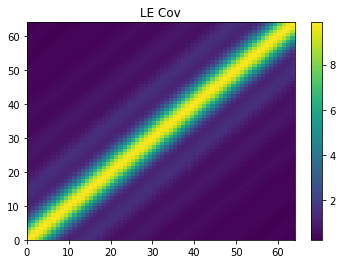

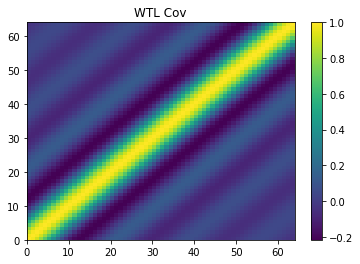

In [9]:
plt.pcolor(ymat.real)
plt.title("LE Cov")
plt.colorbar()
plt.show()
#plt.pcolor(ymat_flag_inv.real)
#plt.show()
#plt.pcolor(cmat.real)
#plt.show()
plt.pcolor(ymat_simple.real)
plt.title("WTL Cov")
plt.colorbar()

Let's look at these matrices in Fourier space. Both are diagonal, as we might expect/hope. However, the LE weights are not uniform, and have a significant DC mode while the WTL weights (by definition) is a diagonal tophat. 

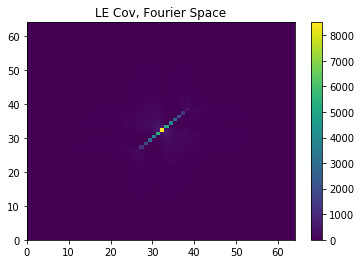

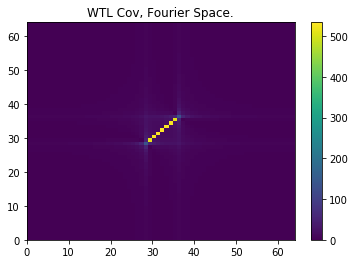

In [10]:
plt.pcolor((np.abs(ft_matrix(ymat,taper='boxcar'))))
plt.title('LE Cov, Fourier Space')
plt.colorbar()
plt.show()
#plt.pcolor(ymat_flag_inv.real)
#plt.show()
#plt.pcolor(cmat.real)
#plt.show()
plt.pcolor((np.abs(ft_matrix(ymat_simple,taper='boxcar'))))
plt.title('WTL Cov, Fourier Space.')
plt.colorbar()
plt.show()

Here is the FT with a blackman-harris window. 

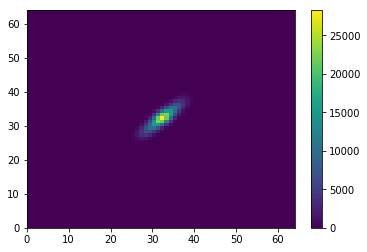

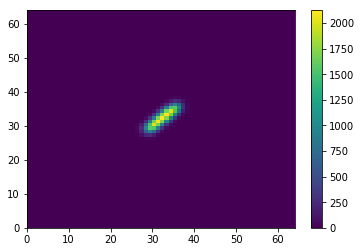

In [11]:
plt.pcolor((np.abs(ft_matrix(ymat,taper='blackmanharris'))))
plt.colorbar()
plt.show()
#plt.pcolor(ymat_flag_inv.real)
#plt.show()
#plt.pcolor(cmat.real)
#plt.show()
plt.pcolor((np.abs(ft_matrix(ymat_simple,taper='blackmanharris'))))
plt.colorbar()
plt.show()

Lets take a look at the diagonals (FTd with a blackman-harris window). 

(100.0, 100000.0)

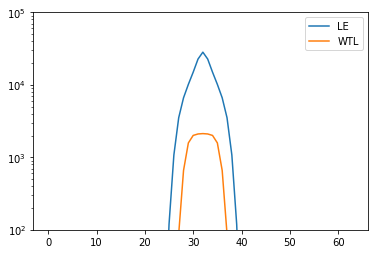

In [12]:
plt.plot(np.diag(np.abs(ft_matrix(ymat,taper='blackmanharris'))),label='LE')
#plt.colorbar()
#plt.show()
#plt.pcolor(ymat_flag_inv.real)
#plt.show()
#plt.pcolor(cmat.real)
#plt.show()
plt.plot(np.diag(np.abs(ft_matrix(ymat_simple,taper='blackmanharris'))),label='WTL')
#plt.colorbar()
plt.legend()
plt.yscale('log')
plt.ylim(1e2,1e5)

Now lets load up some PRISIM simulated foregrounds and add a 21cm signal at the $10^{-4}$ level. 

In [13]:
fgsim=np.load('Simulations/2017-11-15-20-29-15/simdata/simvis.npz')
#print(fgsim.files)
#print(fgsim['bl'])
#print(fgsim['freq'])
#print(fgsim['skyvis_freq'].shape)
#plt.plot(fgsim['skyvis_freq'][0,:,0])
fgamp = np.sqrt(np.mean((np.abs(fgsim['vis_freq'])**2).flatten()))
fg_and_sig = fgsim['skyvis_freq']+1e-4*(np.random.randn(*fgsim['skyvis_freq'].shape)\
                              + 1j*np.random.randn(*fgsim['skyvis_freq'].shape))\
                            *fgamp/np.sqrt(2.)

Now define a method to compute power spectrum of foregrounds using covariance approximations.

In [14]:
CINV_DICT={}
def power_spectrum_simulation(bl_index, Df=400.,  Dtau = None, taper = 'boxcar', normalize = 'I',  reg=0,  ndelays = None, unitless = True, channel_flags=[],get_h=False,weighting = 'I',noise_amp=0.):
    '''
    
    '''
    bl_len = fgsim['bl_length'][bl_index]
    nf = len(fgsim['freq'])
    ckey = (weighting,nf,Df,bl_len,reg)+tuple(channel_flags)
    if not ckey in CINV_DICT:
        if ndelays is None:
            ndelays = nf
        if weighting == 'LE':
            ymat = wedge_cov_an(nf,Df,bl_len)+reg*np.identity(nf)
            ymat = ymat+reg*np.identity(nf)*np.mean(np.diagonal(ymat))
        elif weighting == 'WTL':
            ymat = wedge_cov_simple(nf,Df,bl_len)
            ymat = ymat+reg*np.identity(nf)*np.mean(np.diagonal(ymat))
        else:
            ymat = np.identity(nf)

        if not weighting == 'I':
            if len(channel_flags)>0:
                ymat_inv = psuedo_inverse(ymat, bad_chans=channel_flags,eta = 1.)
            else: 
                ymat_inv = np.linalg.inv(ymat)
        else:
            ymat_inv = np.identity(nf,dtype=complex)
        CINV_DICT[ckey] = ymat_inv
    
    n1 = noise_amp*(np.random.randn(nf)\
                              + 1j*np.random.randn(nf))/np.sqrt(2.)
    n2 = noise_amp*(np.random.randn(nf)\
                              + 1j*np.random.randn(nf))/np.sqrt(2.)
    
    return power_spectrum(fg_and_sig[bl_index,:,0]+n1,fg_and_sig[bl_index,:,0]+n2, Df, Dtau,taper, normalize,  reg, ndelays, unitless, channel_flags, r_matrix = CINV_DICT[ckey],get_h=get_h)


condition=3.856835e+00


/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


condition=1.028378e+16
condition=1.064639e+16


/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'NO Flagged Channels. b = 14.60 meters')

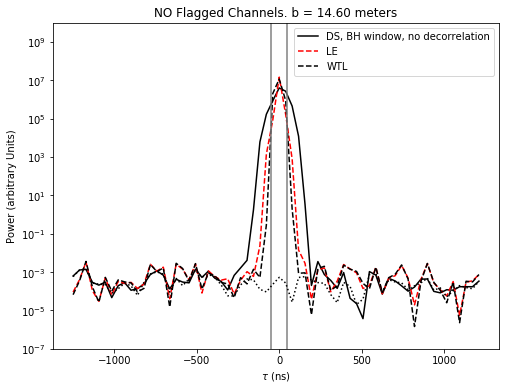

In [15]:
blind = 0

x,y,w,_,_=power_spectrum(fg_and_sig[blind,:,0],fg_and_sig[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris',normalize='I')
xbn,ybn,wbn,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=64,weighting='LE',reg=1e-9)
xbm,ybm,wbm,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=64,weighting='WTL',reg=1e-9)
xt,pt,wt,_,_=power_spectrum((fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],(fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris')

#for m in range(10):
#    ybna=ybna+power_spectrum(draws[m],draws[m],400e3,window='blackmanharris',normalize=True,ndelays=64)[1]
#ybna/=10.
plt.plot(x,np.abs(y),ls='-',color='k',label='DS, BH window, no decorrelation')
plt.plot(xbn,np.abs(ybn),ls='--',color='r',label='LE')
plt.plot(xbm,np.abs(ybm),ls='--',color='k',label='WTL')

plt.axvline(fgsim['bl_length'][blind]/3e8*1e9,ls='-',color='grey')
plt.axvline(-fgsim['bl_length'][blind]/3e8*1e9,ls='-',color='grey')
#plt.plot(xbn1,np.abs(ybn1),ls='--',color='grey',label='Decorrelation with \nEmprical FG Covariance Matrix')

plt.plot(xt,pt,color='k',ls=':')
plt.legend()
#plt.plot(xbn,ybna)
plt.yscale('log')
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('Power (arbitrary Units)')
plt.gcf().set_size_inches(8,6)
plt.ylim(1e-7
         ,1e10)
plt.title('NO Flagged Channels. b = %.2f meters'%(fgsim['bl_length'][blind]))

/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


condition=4.230330e+16
condition=2.162012e+16


Text(0.5,1,'No Flagged Channels. b = 38.63 meters')

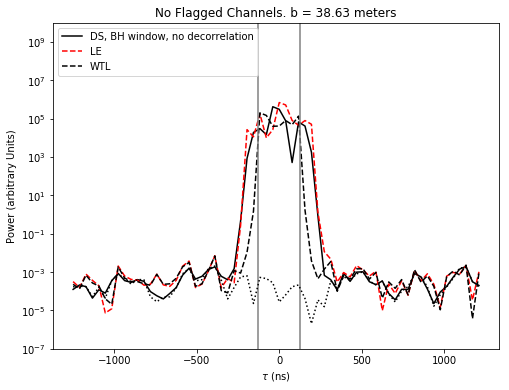

In [16]:
blind = 10

x,y,w,_,_=power_spectrum(fg_and_sig[blind,:,0],fg_and_sig[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris',normalize='I')
xbn,ybn,wbn,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=64,weighting='LE',reg=1e-9)
xbm,ybm,wbm,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=64,weighting='WTL',reg=1e-9)
xt,pt,wt,_,_=power_spectrum((fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],(fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris')

#for m in range(10):
#    ybna=ybna+power_spectrum(draws[m],draws[m],400e3,window='blackmanharris',normalize=True,ndelays=64)[1]
#ybna/=10.
plt.plot(x,np.abs(y),ls='-',color='k',label='DS, BH window, no decorrelation')
plt.plot(xbn,np.abs(ybn),ls='--',color='r',label='LE')
plt.plot(xbm,np.abs(ybm),ls='--',color='k',label='WTL')

plt.axvline(fgsim['bl_length'][blind]/3e8*1e9,ls='-',color='grey')
plt.axvline(-fgsim['bl_length'][blind]/3e8*1e9,ls='-',color='grey')

#plt.plot(xbn1,np.abs(ybn1),ls='--',color='grey',label='Decorrelation with \nEmprical FG Covariance Matrix')

plt.plot(xt,pt,color='k',ls=':')
plt.legend()
#plt.plot(xbn,ybna)
plt.yscale('log')
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('Power (arbitrary Units)')
plt.gcf().set_size_inches(8,6)
plt.ylim(1e-7
         ,1e10)
plt.title('No Flagged Channels. b = %.2f meters'%(fgsim['bl_length'][blind]))

condition=3.764938e+00


/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


condition=4.908096e+16
condition=3.885125e+16


Text(0.5,1,'2 Flagged Channels. b = 14.60 meters')

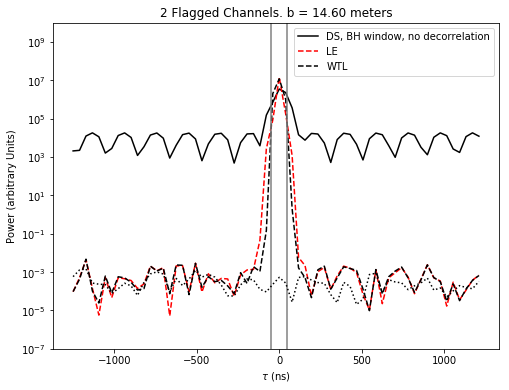

In [17]:
blind = 0

x,y,w,_,_=power_spectrum(fg_and_sig[blind,:,0],fg_and_sig[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris',normalize='I',channel_flags=[48,35])
xbn,ybn,wbn,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=64,weighting='LE',reg=1e-9,channel_flags=[48,35])
xbm,ybm,wbm,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=64,weighting='WTL',reg=1e-9,channel_flags=[48,35])
xt,pt,wt,_,_=power_spectrum((fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],(fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris')

#for m in range(10):
#    ybna=ybna+power_spectrum(draws[m],draws[m],400e3,window='blackmanharris',normalize=True,ndelays=64)[1]
#ybna/=10.
plt.plot(x,np.abs(y),ls='-',color='k',label='DS, BH window, no decorrelation')
plt.plot(xbn,np.abs(ybn),ls='--',color='r',label='LE')
plt.plot(xbm,np.abs(ybm),ls='--',color='k',label='WTL')

plt.axvline(fgsim['bl_length'][blind]/3e8*1e9,ls='-',color='grey')
plt.axvline(-fgsim['bl_length'][blind]/3e8*1e9,ls='-',color='grey')

#plt.plot(xbn1,np.abs(ybn1),ls='--',color='grey',label='Decorrelation with \nEmprical FG Covariance Matrix')

plt.plot(xt,pt,color='k',ls=':')
plt.legend()
#plt.plot(xbn,ybna)
plt.yscale('log')
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('Power (arbitrary Units)')
plt.gcf().set_size_inches(8,6)
plt.ylim(1e-7
         ,1e10)
plt.title('2 Flagged Channels. b = %.2f meters'%(fgsim['bl_length'][blind]))

/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


condition=1.785877e+17
condition=5.767408e+16


Text(0.5,1,'2 Flagged Channels. b = 38.63 meters')

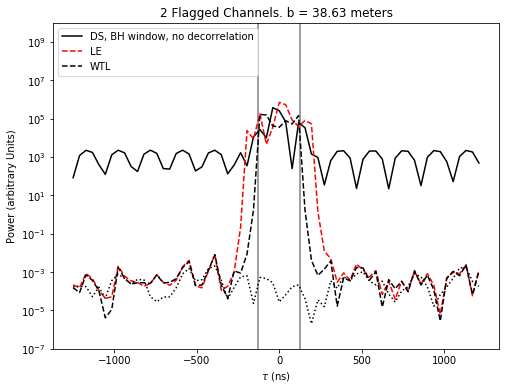

In [18]:
blind = 10

x,y,w,_,_=power_spectrum(fg_and_sig[blind,:,0],fg_and_sig[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris',normalize='I',channel_flags=[48,35])
xbn,ybn,wbn,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=64,weighting='LE',reg=1e-9,channel_flags=[48,35])
xbm,ybm,wbm,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=64,weighting='WTL',reg=1e-9,channel_flags=[48,35])
xt,pt,wt,_,_=power_spectrum((fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],(fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris')

plt.axvline(fgsim['bl_length'][blind]/3e8*1e9,ls='-',color='grey')
plt.axvline(-fgsim['bl_length'][blind]/3e8*1e9,ls='-',color='grey')

#for m in range(10):
#    ybna=ybna+power_spectrum(draws[m],draws[m],400e3,window='blackmanharris',normalize=True,ndelays=64)[1]
#ybna/=10.
plt.plot(x,np.abs(y),ls='-',color='k',label='DS, BH window, no decorrelation')
plt.plot(xbn,np.abs(ybn),ls='--',color='r',label='LE')
plt.plot(xbm,np.abs(ybm),ls='--',color='k',label='WTL')

#plt.plot(xbn1,np.abs(ybn1),ls='--',color='grey',label='Decorrelation with \nEmprical FG Covariance Matrix')

plt.plot(xt,pt,color='k',ls=':')
plt.legend()
#plt.plot(xbn,ybna)
plt.yscale('log')
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('Power (arbitrary Units)')
plt.gcf().set_size_inches(8,6)
plt.ylim(1e-7
         ,1e10)
plt.title('2 Flagged Channels. b = %.2f meters'%(fgsim['bl_length'][blind]))

/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


condition=1.990377e+17
condition=6.846900e+16


Text(0.5,1,'2 Flagged Channels. b = 52.64 meters')

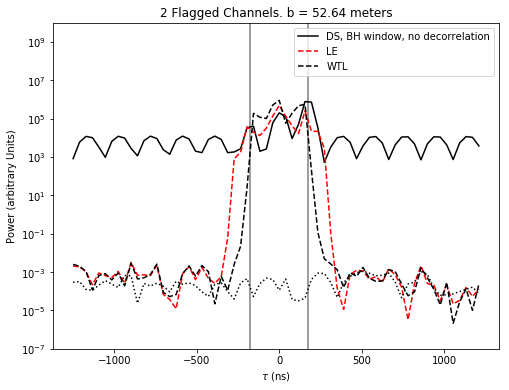

In [19]:
blind = 23

x,y,w,_,_=power_spectrum(fg_and_sig[blind,:,0],fg_and_sig[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris',normalize='I',channel_flags=[48,35])
xbn,ybn,wbn,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=64,weighting='LE',reg=1e-9,channel_flags=[48,35])
xbm,ybm,wbm,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=64,weighting='WTL',reg=1e-9,channel_flags=[48,35])
xt,pt,wt,_,_=power_spectrum((fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],(fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris')

plt.axvline(fgsim['bl_length'][blind]/3e8*1e9,ls='-',color='grey')
plt.axvline(-fgsim['bl_length'][blind]/3e8*1e9,ls='-',color='grey')

#for m in range(10):
#    ybna=ybna+power_spectrum(draws[m],draws[m],400e3,window='blackmanharris',normalize=True,ndelays=64)[1]
#ybna/=10.
plt.plot(x,np.abs(y),ls='-',color='k',label='DS, BH window, no decorrelation')
plt.plot(xbn,np.abs(ybn),ls='--',color='r',label='LE')
plt.plot(xbm,np.abs(ybm),ls='--',color='k',label='WTL')

#plt.plot(xbn1,np.abs(ybn1),ls='--',color='grey',label='Decorrelation with \nEmprical FG Covariance Matrix')

plt.plot(xt,pt,color='k',ls=':')
plt.legend()
#plt.plot(xbn,ybna)
plt.yscale('log')
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('Power (arbitrary Units)')
plt.gcf().set_size_inches(8,6)
plt.ylim(1e-7
         ,1e10)
plt.title('2 Flagged Channels. b = %.2f meters'%(fgsim['bl_length'][blind]))

## Can we use a regularization factor that matches thermal noise but is larger than the signal?

80
condition=1.237368e+16


/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5,1,'0 Flagged Channels. b = 52.64 meters')

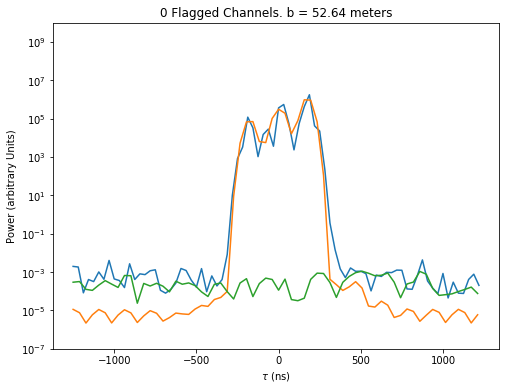

In [21]:
ndraws = 10000
namp = fgamp*10**(-3.5)
nf = len(fg_and_sig[blind,:,0])
print(nf)
my = np.zeros(nf,dtype=complex)
for drawnum in range(ndraws):
    x,y,w,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=nf,weighting='LE',reg=1e-7,channel_flags=[],noise_amp=namp)
    my+=y
xfg,pfg,wfg,_,_=power_spectrum((fgsim['skyvis_freq'])[blind,:,0],(fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris')
xt,pt,wt,_,_=power_spectrum((fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],(fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=64,taper='blackmanharris')
my/=ndraws
plt.plot(x,np.abs(my))
plt.plot(xfg,np.abs(pfg))
plt.plot(xt,np.abs(pt))
plt.yscale('log')
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('Power (arbitrary Units)')
plt.gcf().set_size_inches(8,6)
plt.ylim(1e-7
         ,1e10)
plt.title('0 Flagged Channels. b = %.2f meters'%(fgsim['bl_length'][blind]))

80


/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


condition=1.329721e+01


Text(0.5,1,'2 Flagged Channels. b = 52.64 meters')

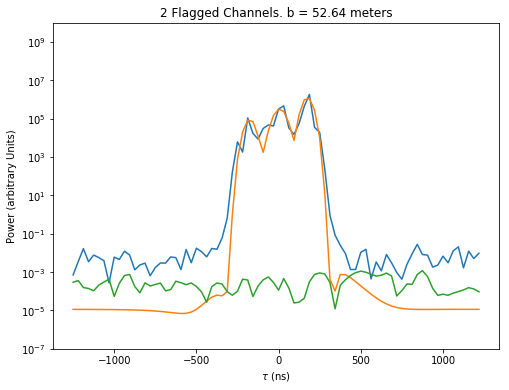

In [23]:
ndraws = 1
namp = fgamp*10.**(-3.5)
nf = len(fg_and_sig[blind,:,0])
print(nf)
my = np.zeros(nf,dtype=complex)
for drawnum in range(ndraws):
    x,y,w,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=nf,weighting='LE',reg=1e-7,channel_flags=[],noise_amp=namp)
    my+=y
xfg,pfg,wfg,_,_=power_spectrum((fgsim['skyvis_freq'])[blind,:,0],(fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=80,taper='blackmanharris')
xt,pt,wt,_,_=power_spectrum((fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],(fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=80,taper='blackmanharris')
my/=ndraws
plt.plot(x,np.abs(my))
plt.plot(xfg,np.abs(pfg))
plt.plot(xt,np.abs(pt))
plt.yscale('log')
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('Power (arbitrary Units)')
plt.gcf().set_size_inches(8,6)
plt.ylim(1e-7
         ,1e10)
plt.title('2 Flagged Channels. b = %.2f meters'%(fgsim['bl_length'][blind]))

80
condition=7.371194e+15


/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ewallwic/miniconda2/envs/hera_pspec_testing/lib/python2.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5,1,'0 Flagged Channels. b = 14.60 meters')

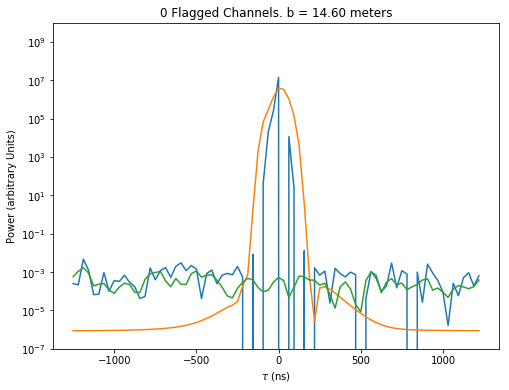

In [26]:
blind=0
ndraws = 10000
namp = fgamp*10**(-3.5)
nf = len(fg_and_sig[blind,:,0])
print(nf)
my = np.zeros(nf,dtype=complex)
for drawnum in range(ndraws):
    x,y,w,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=nf,weighting='LE',reg=1e-7,channel_flags=[35,48],noise_amp=namp)
    my+=y
xfg,pfg,wfg,_,_=power_spectrum((fgsim['skyvis_freq'])[blind,:,0],(fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=nf,taper='blackmanharris')
xt,pt,wt,_,_=power_spectrum((fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],(fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=nf,taper='blackmanharris')
my/=ndraws
plt.plot(x,np.real(my))
plt.plot(xfg,np.real(pfg))
plt.plot(xt,np.real(pt))
plt.yscale('log')
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('Power (arbitrary Units)')
plt.gcf().set_size_inches(8,6)
plt.ylim(1e-7
         ,1e10)
plt.title('0 Flagged Channels. b = %.2f meters'%(fgsim['bl_length'][blind]))

In [ ]:
ndraws = 100000
namp = fgamp*10**(-3.5)
nf = len(fg_and_sig[blind,:,0])
print(nf)
my = np.zeros(nf,dtype=complex)
for drawnum in range(ndraws):
    x1 = fg_and_sig[blind,:,0] + n1
    x2 = fg_and_sig[blind,:,0] + n2
    x,y,w,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=nf,weighting='LE',reg=1e-7,channel_flags=[35,48],noise_amp=namp)
    my+=y
xfg,pfg,wfg,_,_=power_spectrum((fgsim['skyvis_freq'])[blind,:,0],(fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=nf,taper='blackmanharris')
xt,pt,wt,_,_=power_spectrum((fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],(fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=nf,taper='blackmanharris')
my/=ndraws
plt.plot(x,np.real(my))
plt.plot(xfg,np.real(pfg))
plt.plot(xt,np.real(pt))
plt.yscale('log')
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('Power (arbitrary Units)')
plt.gcf().set_size_inches(8,6)
plt.ylim(1e-7
         ,1e10)
plt.title('0 Flagged Channels. b = %.2f meters'%(fgsim['bl_length'][blind]))

In [ ]:
ndraws = 1
namp = fgamp*10**(-3.5)
nf = len(fg_and_sig[blind,:,0])
print(nf)
my = np.zeros(nf,dtype=complex)
for drawnum in range(ndraws):
    x,y,w,_,_=power_spectrum_simulation(blind,Df=400e3,taper='boxcar',normalize='H^-1',ndelays=nf,weighting='LE',reg=1e-7,channel_flags=[35,48],noise_amp=namp)
    my+=y
xfg,pfg,wfg,_,_=power_spectrum((fgsim['skyvis_freq'])[blind,:,0],(fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=nf,taper='blackmanharris')
xt,pt,wt,_,_=power_spectrum((fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],(fg_and_sig-fgsim['skyvis_freq'])[blind,:,0],Df=400e3,ndelays=nf,taper='blackmanharris')
my/=ndraws
plt.plot(x,np.real(my))
plt.plot(xfg,np.real(pfg))
plt.plot(xt,np.real(pt))
plt.yscale('log')
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('Power (arbitrary Units)')
plt.gcf().set_size_inches(8,6)
plt.ylim(1e-7
         ,1e10)
plt.title('0 Flagged Channels. b = %.2f meters'%(fgsim['bl_length'][blind]))